In [1]:
from astropy.io import fits
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle, RegularPolygon

plt.rcParams.update({
    'font.family'      : 'serif',
    'font.size'        : 24,
    'font.serif'       : 'Georgia',
    'axes.labelsize'   : 'large',
    'mathtext.fontset' : 'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  : 'in',
    'ytick.direction'  : 'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

In [2]:
#Load in KiDS data
with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/KiDS_SOM_catalog_18Jul24.fits') as cat:
    KiDS_cat = Table(cat[1].data)

#Load in GAMA data
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_17Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [3]:
#Select the needed data
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 0.4
KiDS_size_cut = KiDS_cat['half_light_radius'] < 5

input_cat = KiDS_cat[KiDS_redshift_cut & KiDS_mag_cut & KiDS_size_cut]

GAMA_mag_cut = GAMA_cat['r_mag'] < 20.5
GAMA_redshift_cut = GAMA_cat['redshift'] < 0.4
GAMA_size_cut = GAMA_cat['half_light_radius'] < 5

labels_cat = GAMA_cat[GAMA_redshift_cut & GAMA_mag_cut & GAMA_size_cut]

input_data = Table([
                    input_cat['r_mag'],
                    # (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col'],
                    input_cat['gr_col'],
                    input_cat['ri_col'],
                    # input_cat['half_light_radius']
                    input_cat['redshift']
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                    #  'radius',
                     'redshift'
                     ])
input_data_names = ['r_mag', 'ug_col', 'gr_col', 'ri_col', 'redshift']

input_stds = Table([
                    input_cat['r_mag_err'],
                    input_cat['ug_col_err'],
                    input_cat['gr_col_err'],
                    input_cat['ri_col_err'],
                    # input_cat['half_light_radius']/20
                    input_cat['redshift_err']
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    # 'radius_err'
                    'redshift_err'
                    ])

for key in input_stds.keys(): input_stds[key] = np.sqrt(input_stds[key])

input_labels = Table([
                      labels_cat['r_mag'],
                      # (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                      labels_cat['ug_col'],
                      labels_cat['gr_col'],
                      labels_cat['ri_col'],
                      # labels_cat['half_light_radius'],
                      labels_cat['redshift'],
                      labels_cat['redshift'],
                      labels_cat['mstar'],
                      ],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      # 'radius',
                      'redshift',
                      'mstar',
                      'pred_redshift'
                      ])

input_label_stds = Table([
                          labels_cat['r_mag_err'],
                          labels_cat['ug_col_err'],
                          labels_cat['gr_col_err'],
                          labels_cat['ri_col_err'],
                          # labels_cat['half_light_radius']/20,
                          [0.01] * len(labels_cat),
                          [0.01] * len(labels_cat),
                          labels_cat['mstar_err'],
                        #   labels_cat['mstar_err']/(labels_cat['mstar'] * np.log(10)),
                          ],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          # 'radius_err',
                          'redshift_err',
                          'pred_redshift_err',
                          'mstar_err',
                          ])

# for key in input_label_stds.keys(): input_label_stds[key] = np.sqrt(input_label_stds[key]) 

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

Len of input data: 626112
Len of labeling data: 46549


In [4]:
import somoclu

In [5]:
n_columns = 20
n_rows = 20

som = somoclu.Somoclu(n_columns = n_columns, n_rows = n_rows,
                      maptype = "toroid", gridtype = "hexagonal", initialization = 'pca',
                      compactsupport = False)

In [6]:
tuple_data = input_data.as_array()
list_data = [list(values) for values in tuple_data]
input_data = np.array(list_data)

In [7]:
som.train(input_data[:8000])

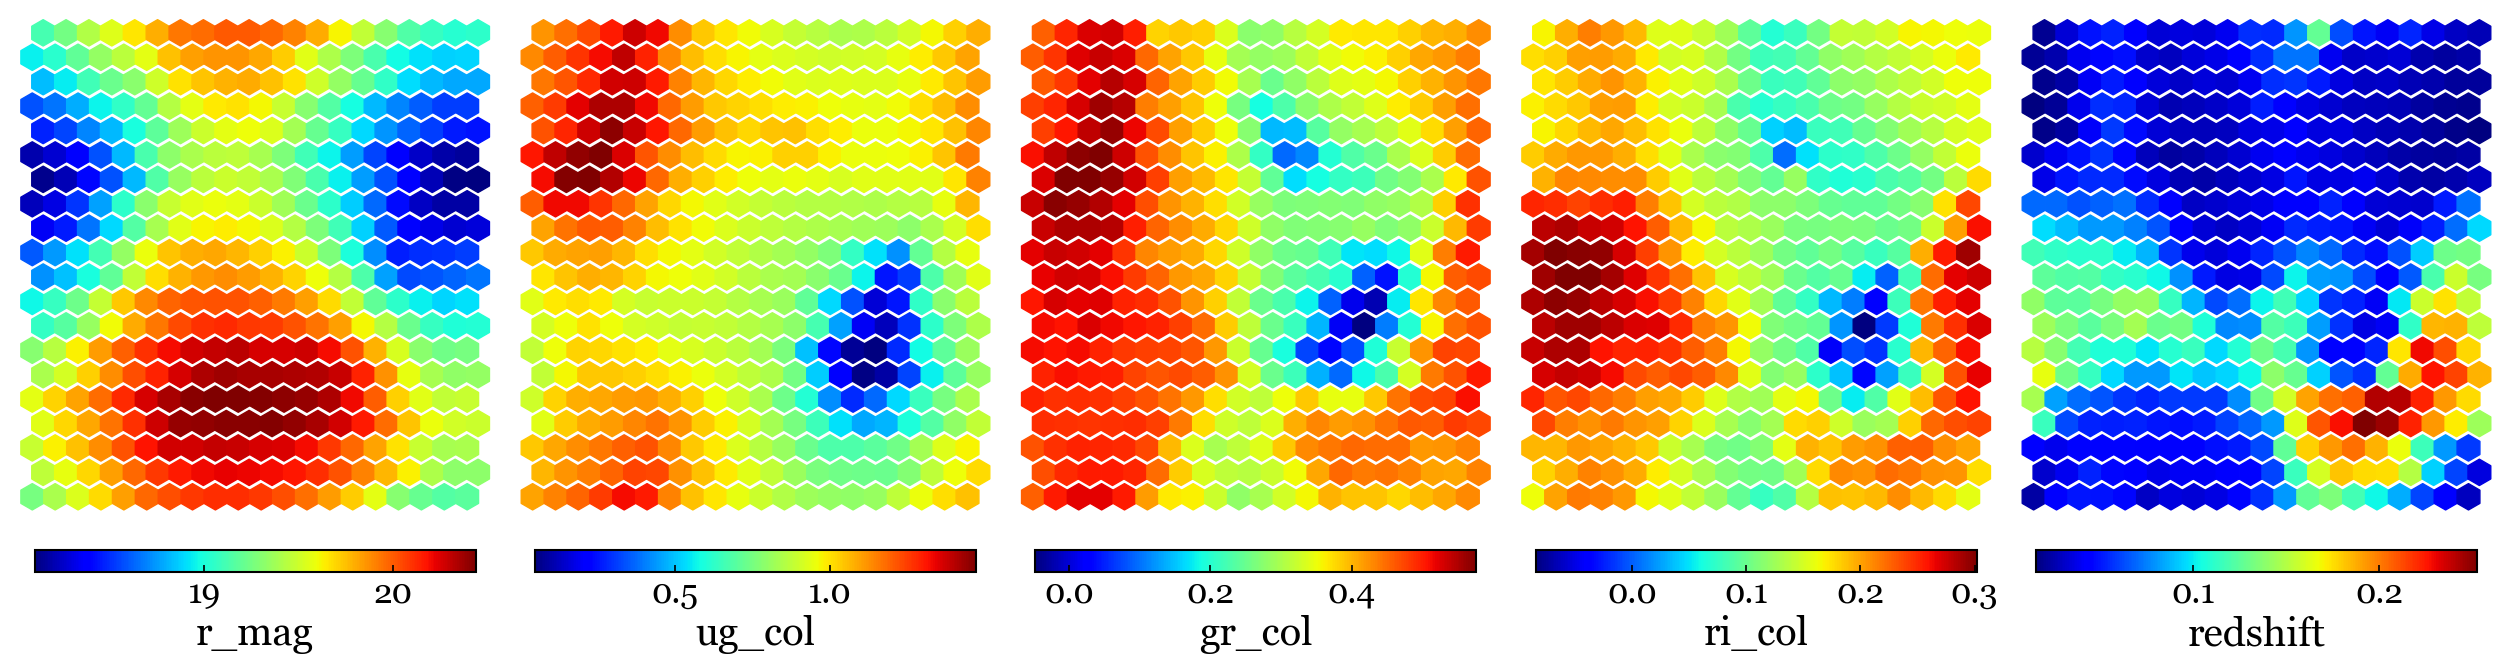

In [26]:
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2
# hexmesh[1][1:] -= 1/12

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)

    map = ax.scatter(*hexmesh, c = som.codebook[..., i], marker = 'h', cmap = 'jet', s = n_columns * 18)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = input_data_names[i], shrink = 0.9)

In [ ]:
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)

    minval = np.nanmin(som.codebook[..., i])
    maxval = np.nanmax(som.codebook[..., i])
    val_range = maxval - minval

    cmap = mpl.colormaps['jet']

    for idx, _ in np.ndenumerate(hexmesh[0]):
        hexagon = RegularPolygon([hexmesh[0][idx],
                                hexmesh[1][idx]], numVertices = 6, radius = 0.0125,
                                color = cmap((som.codebook[*idx, i] - minval)/val_range))
        ax.add_patch(hexagon)

    ax.axis('off')

    fig.colorbar(mappable = mpl.cm.ScalarMappable(norm = mpl.colors.Normalize(vmin = minval, vmax = maxval), cmap = 'jet'),
                 ax = ax, location = 'bottom', label = input_data_names[i])

In [32]:
surface_state = som.get_surface_state()b

In [51]:
np.unravel_index(surface_state[0].argmin(), (n_rows, n_columns))

(3, 7)

In [52]:
tuple_labels = input_labels.as_array()
list_labels = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

In [54]:
np.shape(input_labels)

(46549, 7)

In [72]:
with_inputs = som.get_surface_state(data = input_labels[:, :5])

In [73]:
without_inputs = som.get_surface_state()

In [74]:
np.shape(with_inputs)

(46549, 400)

In [78]:
bmus_with_inputs = som.get_bmus(activation_map = with_inputs)

In [79]:
np.shape(bmus_with_inputs)

(46549, 2)

In [91]:
labeled_map_values = np.empty((n_rows, n_columns, 2), dtype = object)
for index, _ in np.ndenumerate(labeled_map_values):
    labeled_map_values[index] = []

labels_activation_map = som.get_surface_state(data = input_labels[:, :5])
labels_bmus = som.get_bmus(activation_map = labels_activation_map)

for vector_index in range(len(input_labels)):
    for param in range(2):
        labeled_map_values[*labels_bmus[vector_index], param].append(input_labels[vector_index, 5 + param])

In [93]:
labeled_map = np.empty((n_rows, n_columns, 2), dtype = float)
for index, values in np.ndenumerate(labeled_map_values):
    labeled_map[index] = np.median(values)

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


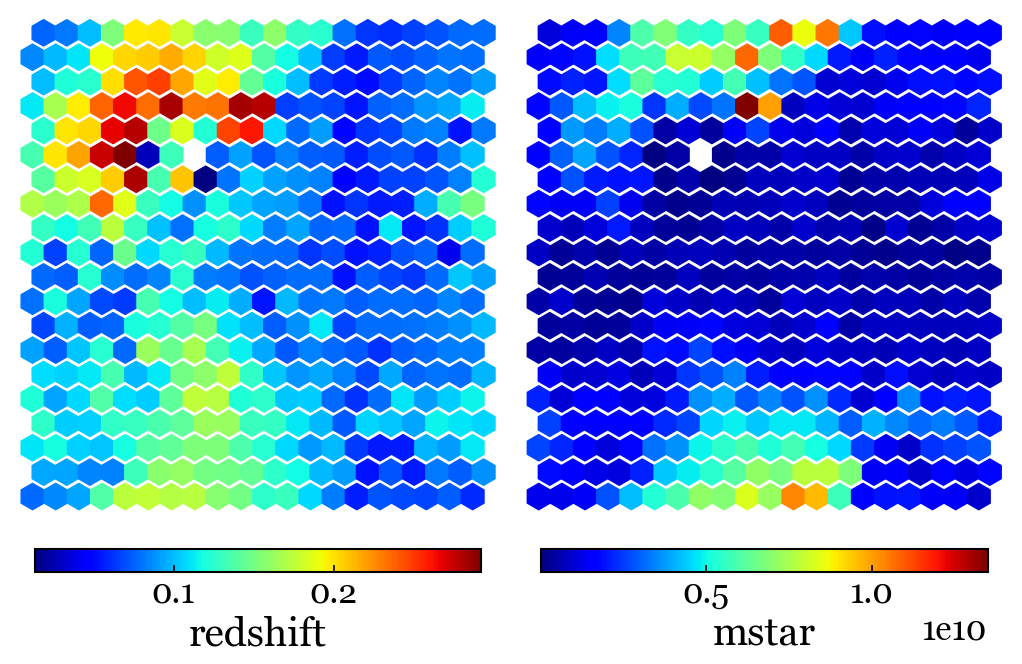

In [98]:
hexmesh = np.meshgrid(np.linspace(0, n_rows, n_rows),
                       np.linspace(0, n_columns, n_columns))

hexmesh[0][1::2] += 1/2
# hexmesh[1][1:] -= 1/12

fig = plt.figure(figsize = (25, 6.5), constrained_layout = True)

for i in range(2):
    ax = fig.add_subplot(1, 5, i + 1)

    map = ax.scatter(*hexmesh, c = labeled_map[..., i], marker = 'h', cmap = 'jet', s = n_columns * 18)
    ax.axis('off')
    fig.colorbar(mappable = map, ax = ax, location = 'bottom', label = ['redshift', 'mstar'][i], shrink = 0.9)

In [111]:
predicted_values = np.empty((len(input_labels), 2))

for i, bmu in enumerate(labels_bmus):
    predicted_values[i] = labeled_map[*bmu]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 0.000e+00,
        1.800e+01, 0.000e+00, 1.900e+01, 5.900e+01, 6.000e+00, 6.500e+01,
        5.200e+01, 1.500e+01, 3.000e+00, 1.270e+02, 6.500e+01, 3.800e+01,
        1.540e+02, 2.290e+02, 1.140e+02, 2.320e+02, 3.340e+02, 1.660e+02,
        2.210e+02, 3.050e+02, 6.510e+02, 4.900e+02, 6.250e+02, 6.140e+02,
        7.530e+02, 5.350e+02, 5.750e+0

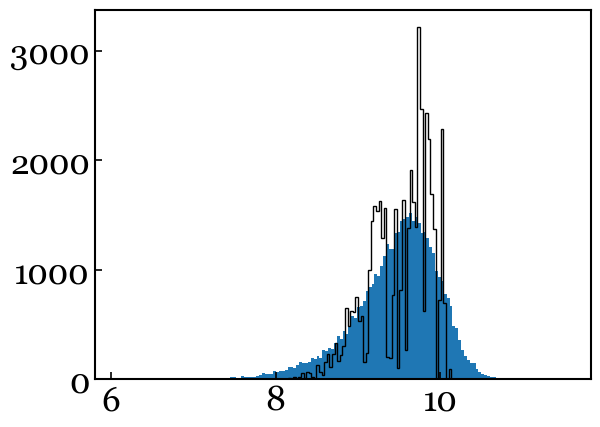

In [117]:
bins = plt.hist(np.log10(input_labels[:, 6]), bins = 'auto')[1]
plt.hist(np.log10(predicted_values[:, 1]), bins = 'auto', histtype = 'step', color = 'black')